<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [55]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt
from scipy.stats import bernoulli, beta   
from math import lgamma

#### IMPORTACIÓN

In [23]:
datos = pd.read_csv('data/cookie_cats.csv')
datos.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


#### TRANSFORMACIÓN

In [24]:
# No es necesario hacer ninguna trabsformacion.
# No tiene nulos, ni fulas repetidas.

#### MUESTREO

In [25]:
cross1 = pd.crosstab(datos['version'],datos['retention_1'])
cross2 = pd.crosstab(datos['version'],datos['retention_7'])
cross1, cross2

(retention_1  False   True
 version                  
 gate_30      24666  20034
 gate_40      25370  20119,
 retention_7  False  True
 version                 
 gate_30      36198  8502
 gate_40      37210  8279)

In [26]:
datos.sum_gamerounds.mean()

51.8724567297564

In [32]:
control = datos[datos.version=='gate_30']

tratamiento = datos[datos.version=='gate_40']

ab_test1=pd.concat([control, tratamiento], axis=0)

ab_test1.reset_index(drop=True, inplace=True)

ab_test1.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,1066,gate_30,0,False,False
3,2101,gate_30,0,False,False
4,2179,gate_30,39,True,False


#### TESTEO PARA 1

In [33]:
# Cuantos jugadores tenemos con la version de 30? Total: 44700
# Cuantos jugadores tenemos con la version de 40? Total: 45489
(datos['version'] == 'gate_30').value_counts()


False    45489
True     44700
Name: version, dtype: int64

In [37]:
# Cuantos jugadores se quedan 1 dia con la de 30? 20 034
# Cuantos jugadores se quedan 1 dia con la de 40? 20 119
cross_1day = pd.crosstab(datos['version'],datos['retention_1'])
cross_1day

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [69]:
imps_ctrl, convs_ctrl = 44700, 20034    # juegan,  siguen jugando despues de un dia

imps_test, convs_test = 45489, 20119    # juegan,  siguen jugando despues de un dia


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Control (Nivel 30): {CR_ctrl}, Test (Nivel 40): {CR_test}'

# Con estos datos podemos conocer los datos de conversion para un dia en las dos versiones.

'Tasas conversion: Control (Nivel 30): 0.4481879194630872, Test (Nivel 40): 0.44228274967574577'

In [41]:
# a prioris
# Se calculan los parámetros para las distribuciones beta a priori.
#En este caso, se utilizan las conversiones y las impresiones para estimar los parámetros de las distribuciones beta para cada grupo.

a_C  = 1+convs_ctrl             # Conversion de la version de control.                              Es el numero de aciertos
b_C = 1+imps_ctrl-convs_ctrl    # Los que juegan menos los que se quedan en la version de control.  Es el numero de fallos

a_T = 1+convs_test              # Conversion de la version de test.
b_T = 1+imps_test-convs_test    # Los que juegan menos los que se quedan en la version test.

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [42]:
beta_control.mean(), beta_test.mean()

(0.44819023757326293, 0.44228528719966587)

In [86]:
from scipy.stats import beta
import numpy as np
from math import lgamma
import matplotlib.pyplot as plt


def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)


def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d
        
        
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))



def calc_prob(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])
    
    

def pico(a, b):
    return (a-1)/(a+b-2)



def plot(betas, names, linf=0.42, lsup=0.48):
    x=np.linspace(linf, lsup, 100)
    for f, n in zip(betas, names):
        y=f.pdf(x)
        y_pico=pico(f.args[0], f.args[1])
        y_var=f.var()
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(n, y_pico, y_var))
        plt.yticks([])
    plt.legend()
    plt.show();

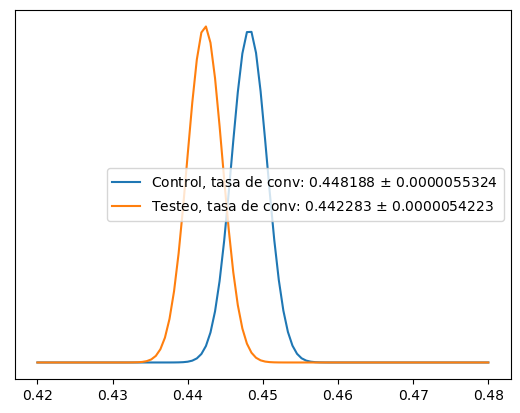

In [87]:
plot([beta_control, beta_test],['Control', 'Testeo'])

#### TESTEO PARA 7

In [88]:
# Cuantos jugadores tenemos con la version de 30? Total: 44700
# Cuantos jugadores tenemos con la version de 40? Total: 45489
(datos['version'] == 'gate_30').value_counts()

False    45489
True     44700
Name: version, dtype: int64

In [90]:
# Cuantos jugadores se quedan 1 dia con la de 30? 20 034
# Cuantos jugadores se quedan 1 dia con la de 40? 20 119
cross_1day = pd.crosstab(datos['version'],datos['retention_7'])
cross_1day

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [97]:
imps_ctrl, convs_ctrl = 44700, 8502   # juegan,  siguen jugando despues de un dia

imps_test, convs_test = 45489, 8279    # juegan,  siguen jugando despues de un dia


CR_ctrl = convs_ctrl/imps_ctrl
CR_test = convs_test/imps_test

f'Tasas conversion: Control (Nivel 30): {CR_ctrl}, Test (Nivel 40): {CR_test}'

# Con estos datos podemos conocer los datos de conversion para un dia en las dos versiones.

'Tasas conversion: Control (Nivel 30): 0.19020134228187918, Test (Nivel 40): 0.18200004396667327'

In [98]:
# a prioris
# Se calculan los parámetros para las distribuciones beta a priori.
#En este caso, se utilizan las conversiones y las impresiones para estimar los parámetros de las distribuciones beta para cada grupo.

a_C  = 1+convs_ctrl             # Conversion de la version de control.                              Es el numero de aciertos
b_C = 1+imps_ctrl-convs_ctrl    # Los que juegan menos los que se quedan en la version de control.  Es el numero de fallos

a_T = 1+convs_test              # Conversion de la version de test.
b_T = 1+imps_test-convs_test    # Los que juegan menos los que se quedan en la version test.

beta_control = beta(a_C, b_C)

beta_test = beta(a_T, b_T)

In [99]:
beta_control.mean(), beta_test.mean()

(0.19021520289919913, 0.18201402475214878)

In [100]:
from scipy.stats import beta
import numpy as np
from math import lgamma
import matplotlib.pyplot as plt


def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)


def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d
        
        
def g0(a, b, c):    
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))



def calc_prob(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])
    
    

def pico(a, b):
    return (a-1)/(a+b-2)



def plot(betas, names, linf=0.165, lsup=0.20):
    x=np.linspace(linf, lsup, 100)
    for f, n in zip(betas, names):
        y=f.pdf(x)
        y_pico=pico(f.args[0], f.args[1])
        y_var=f.var()
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(n, y_pico, y_var))
        plt.yticks([])
    plt.legend()
    plt.show();

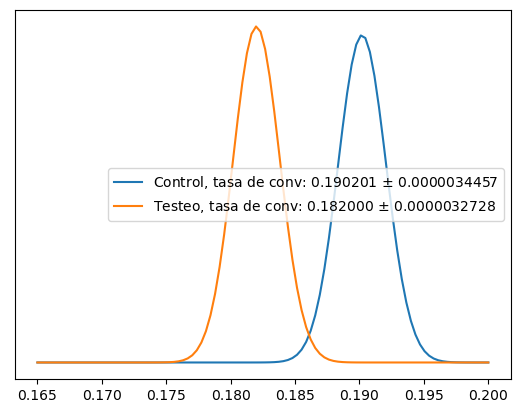

In [101]:
plot([beta_control, beta_test],['Control', 'Testeo'])

#### CONCLUSIÓN

### UN DIA

El rato de conversion es mayor en la version de control (Nivel 30) que en la version de test (Nivel 40). El ratio de conversion empeora en un 1.32%.

### SIETE DIAS

El rato de conversion es mayor en la version de control (Nivel 30) que en la version de test (Nivel 40). El ratio de conversion empeora en un porcentaje mayor que en un dia.

### CONCLUSION FINAL

El consejo seria no cambiar de version y mantener la version de control en el nivel 30.